In [1]:
# Integration of myeloid cells using scvi-tools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

from matplotlib.pyplot import rc_context

Global seed set to 0
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=80, frameon=False, color_map='viridis_r', dpi_save=600)
palette_d = ['#378C4F', '#6DB6FFFF', '#F5CDCD', '#D9579B', '#A59ACB', '#7464AA', '#7BBC5E',  '#006DDBFF', '#B6DBFFFF', '#E2A7CC', '#924900FF']

In [3]:
adata_sc = scvi.data.read_h5ad('scRNA_myeanno.h5ad')

In [4]:
adata_sn = scvi.data.read_h5ad('snRNA_myeanno.h5ad')

In [5]:
adata = adata_sc.concatenate(adata_sn)

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata

AnnData object with n_obs × n_vars = 18678 × 16294
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'stress_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'batch'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [7]:
adata.write('myeloid_unintegrated.h5ad')

In [7]:
adata.layers['counts'] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [9]:
# select HVGs
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key="sampletype",
    subset=True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [8]:
adata.obs['sampletype']

PNT1_GTTACGAAGAGGTTAT-1-0    scRNA-seq
PNT1_ACTGATGTCCTCACCA-1-0    scRNA-seq
PNT1_ATGGGTTTCGACACTA-1-0    scRNA-seq
PNT1_TCCATCGTCAGGAACG-1-0    scRNA-seq
PNT1_GGAACCCCAGAATTCC-1-0    scRNA-seq
                               ...    
RT3_GCCCAGAAGGGTGAGG-1-1     snRNA-seq
RT3_AAGTACCCAATGTCAC-1-1     snRNA-seq
RT3_ACTTAGGGTGTTAGCT-1-1     snRNA-seq
RT3_ATGGTTGAGGGTACAC-1-1     snRNA-seq
RT3_CTCCAACCAAATGAAC-1-1     snRNA-seq
Name: sampletype, Length: 18678, dtype: object

In [10]:
# setup anndata
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=["batch", "patient_id"],
    continuous_covariate_keys=["mt_ratio", "ribo_ratio"]
)

In [11]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='nb')

In [12]:
vae.train(max_epochs=500, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 439/500:  88%|████████████████████████████████████▉     | 439/500 [08:27<01:10,  1.16s/it, loss=1.27e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1282.807. Signaling Trainer to stop.


In [13]:
# get latent representation 
adata.obsm['X_scvi'] = vae.get_latent_representation()
adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size=10e4)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


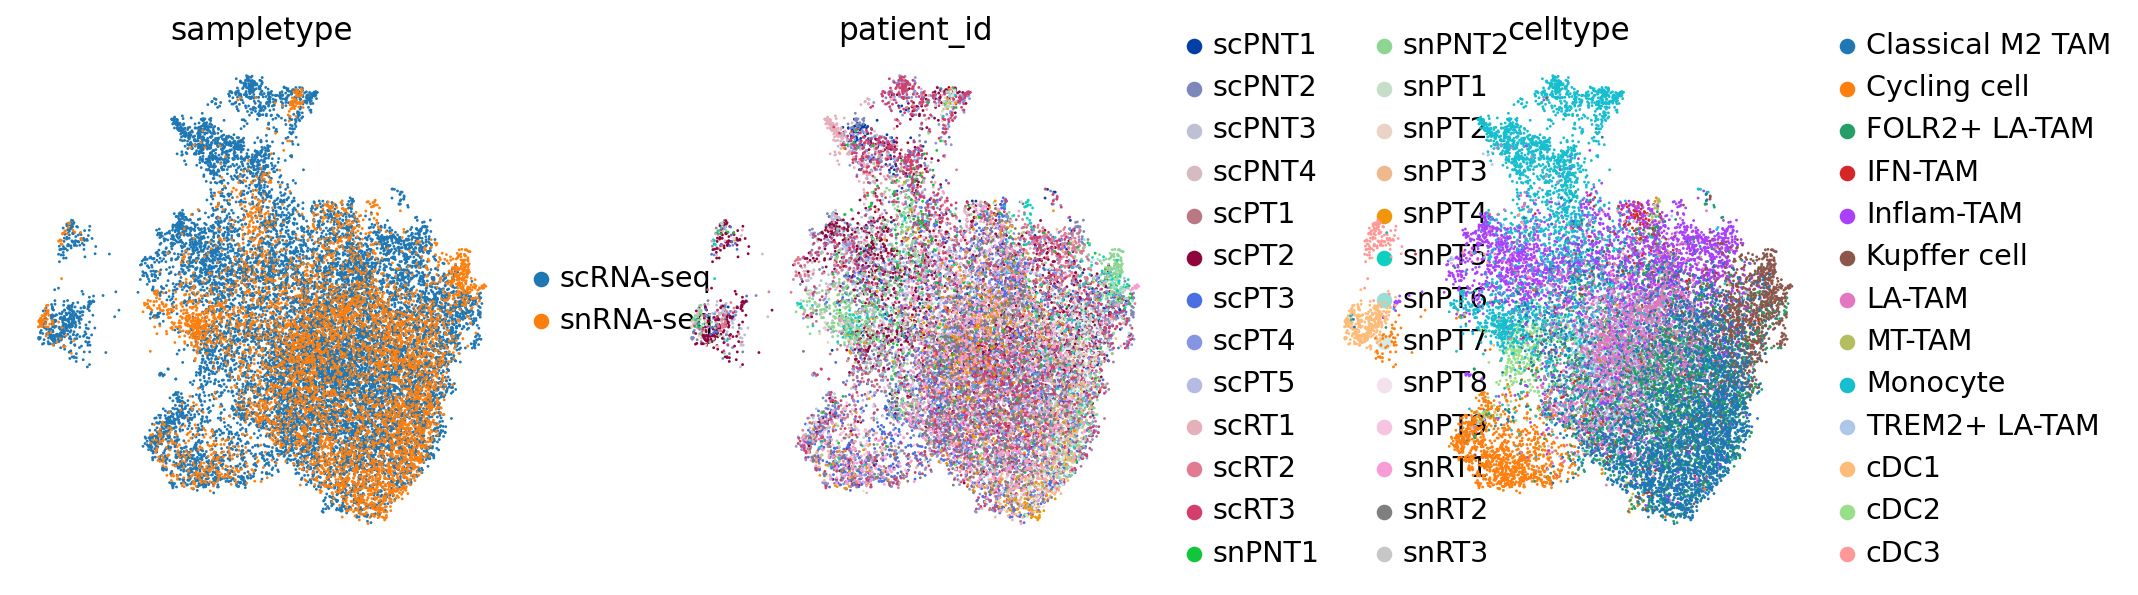

In [14]:
# use the corrected cell embeddings from scvi
sc.pp.neighbors(adata, use_rep='X_scvi')
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["sampletype", "patient_id", "celltype"],
    frameon=False
)

In [15]:
# integration with scANVI
# we here assume that cells from snRNA-seq is un-annotated
adata.obs["celltype_scanvi"] = 'Unknown'
sc_mask = adata.obs['sampletype'] == "scRNA-seq"
adata.obs["celltype_scanvi"][sc_mask] = adata.obs.celltype[sc_mask].values

/tmp/ipykernel_518/1013114048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["celltype_scanvi"][sc_mask] = adata.obs.celltype[sc_mask].values


In [16]:
np.unique(adata.obs["celltype_scanvi"], return_counts = True)

(array(['Classical M2 TAM', 'Cycling cell', 'FOLR2+ LA-TAM', 'IFN-TAM',
        'Inflam-TAM', 'Kupffer cell', 'MT-TAM', 'Monocyte',
        'TREM2+ LA-TAM', 'Unknown', 'cDC1', 'cDC2', 'cDC3'], dtype=object),
 array([1143,  908, 3164,  341, 2466,  864,  263, 1861, 1043, 5643,  297,
         557,  128]))

In [17]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key="celltype_scanvi",
)

In [37]:
# model training
lvae.train(max_epochs=50)

INFO     Training for 50 epochs.                                                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████████████████████████████████████████| 50/50 [02:02<00:00,  2.47s/it, loss=1.33e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████████████████████████████████████████| 50/50 [02:02<00:00,  2.46s/it, loss=1.33e+03, v_num=1]


In [38]:
# predict labels in snRNA-seq, and get the latent space
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
adata.layers['scanvi_normalized'] = lvae.get_normalized_expression(library_size=10e4)

In [39]:
# use the corrected cell embeddings from scanvi
# the label prediction from scanvi seem to be raletively goo# 
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.umap(adata, min_dist=0.2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [3]:
adata = sc.read_h5ad('myeloid_integrated.h5ad')

In [9]:
sc.tl.umap(adata, min_dist=0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


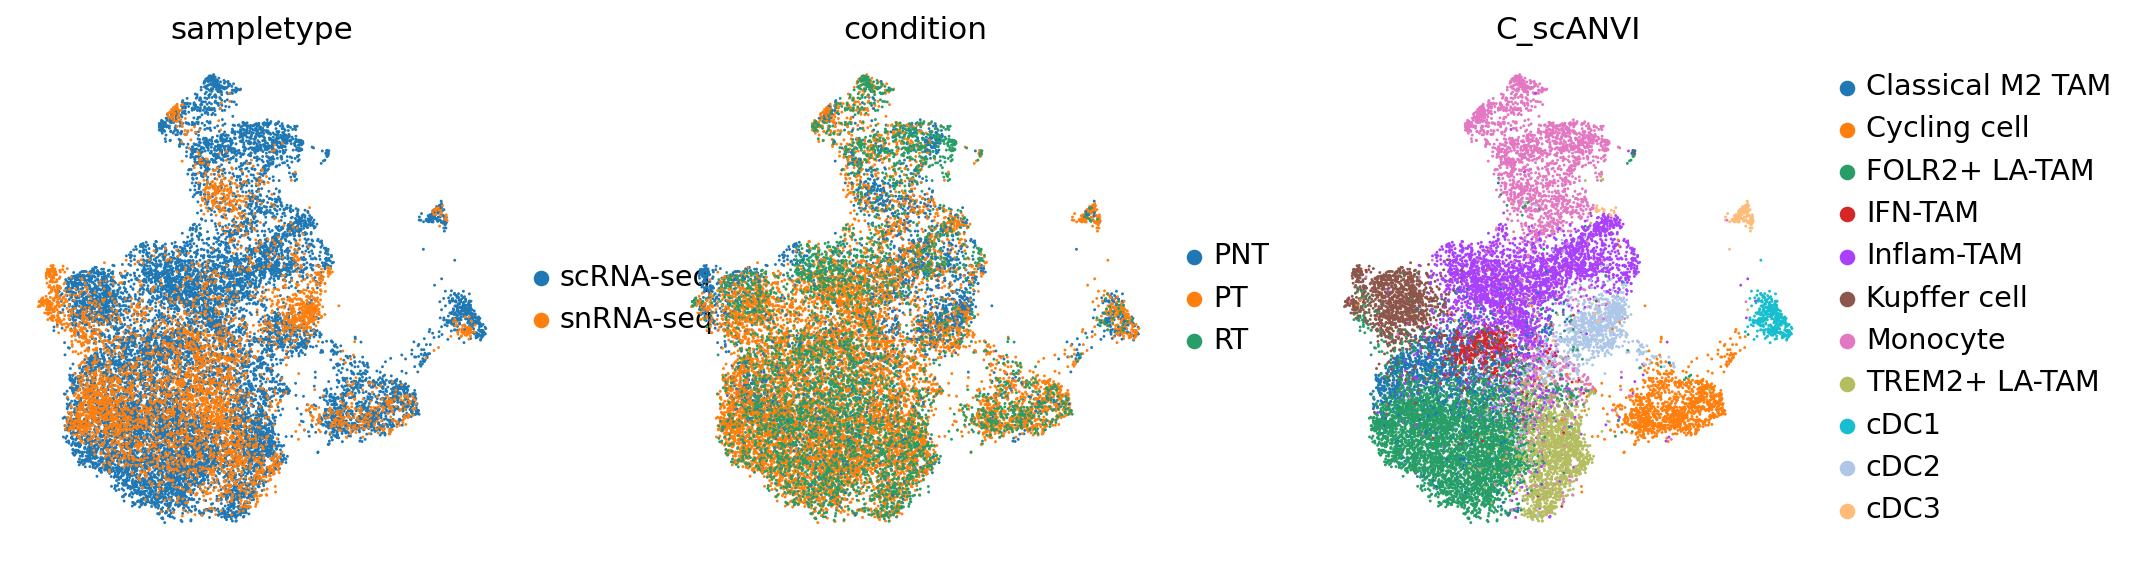

In [10]:
sc.pl.umap(
    adata,
    color=["sampletype", "condition", "C_scANVI"],
    frameon=False
)

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


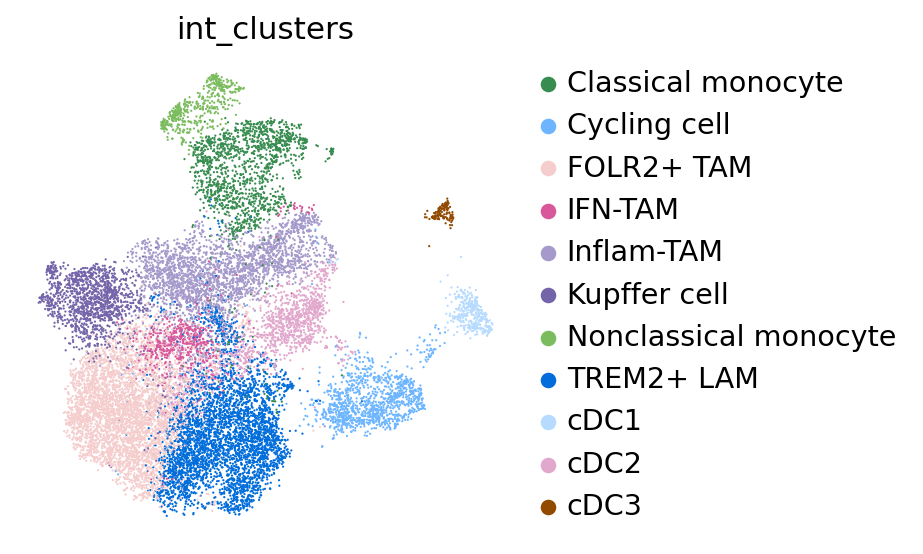

In [36]:
sc.pl.umap(adata, color = ['int_clusters'], frameon=False, palette=palette_d, s=4, save='_myeloid_lanscape.pdf')

In [1]:
# downstream analysis using scanvi predicted labels
sc.pl.umap(adata, color=['TREM2', 'FOLR2', 'SPP1', 'MRC1', 'IFIT1', 'CD163', 'CCL4', 'KLF2'], s=50, layer='scanvi_normalized')

NameError: name 'sc' is not defined

In [18]:
# clustering on the scanvi latent space
sc.tl.leiden(adata, key_added='scanvi_leiden', resolution=0.7)

running Leiden clustering
    finished: found 16 clusters and added
    'scanvi_leiden_0.9', the cluster labels (adata.obs, categorical) (0:00:01)


/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


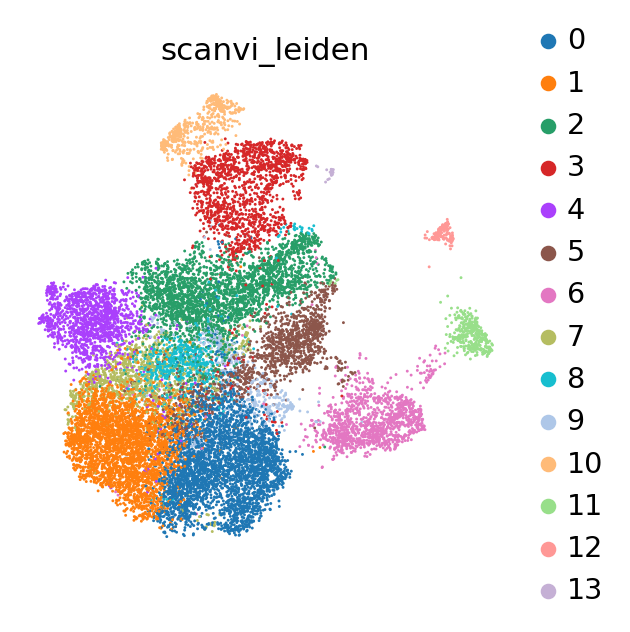

In [21]:
sc.pl.umap(adata, color=['scanvi_leiden'])

In [7]:
# find markers for each cluster
adata.uns['log1p']['base'] = None # solve the key error
sc.tl.rank_genes_groups(adata, 'scanvi_leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


In [8]:
# top 20 genes in each clusters
pd.set_option('display.max_columns', None)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0        1         2         3        4        5       6        7  \
0      GPNMB     MRC1      FOSB      FCN1    VCAM1    CIITA   TOP2A    ITM2B   
1       CTSB   MS4A4A    DNAJB1      VCAN     SDC3     JAML   HMGB2      MAF   
2       MSR1   MS4A6A     HSPH1    S100A8    CD163   STK17B   PCLAF    GPR34   
3      FABP5  SELENOP     NR4A1  SLC25A37     CD5L  ANKRD44    SMC4   KCTD12   
4     PLA2G7    F13A1    HSPA1A     NAMPT   TCF7L2   SLC8A1     DEK  SELENOP   
5        NPL     WWP1     NR4A2      SRGN  SLC40A1   SAMHD1   LMNB1   MS4A6A   
6      ANXA2     DAB2      JUND      CD44  EPB41L2   FCGR2B  NUSAP1     CD14   
7        CD9  SLC40A1      CD83    S100A9     WWP1     PAK1   MKI67  SLC40A1   
8   ARHGAP10      MAF      ATF3       LYZ   CXCL12     RTN1   STMN1      A2M   
9       SPP1     NRP1     ZFP36    S100A6      AXL      AHR    TMPO    MS4A7   
10    LGALS3  SLCO2B1    HSPA1B     FOSL2     PDK4  CLEC10A  NUCKS1     DAB2   
11      MGLL    STAB1  HSP90AA1      BTG1   LILRB5     FLT3   CLSPN     CD74   
12      CTSD     IGF1     HSPD1    SLC2A3    MS4A7  SLC38A1   HMGN2  HLA-DMB   
13      LGMN    CD163      BAG3      SOD2    SASH1     AOAH    NASP     MAFB   
14     TREM2  CD163L1      SRGN   SLC11A1     RGL1    PTPRC    TUBB     C1QC   
15      MPP1    GPR34    DNAJA1     TREM1    GFRA2    UVRAG   CENPK     C1QA   
16      CSTB     SNX6      KLF4  SERPINA1      DST    SMAP2    PRC1    TXNIP   
17     MYO1E   FRMD4B  HSP90AB1     HSPH1   KCNMA1    ITPR1    TYMS     C1QB   
18    ABHD12    CSF1R      JUNB      CSTA     CPVL  IL13RA1   CENPF    CEBPD   
19      LIPA    MS4A7     HSPE1      MCL1     LIPA    MBNL1  TUBA1B    C3AR1   

           8       9        10        11        12       13  
0      STAT1    MT1X      FCN1      IDO1     BIRC3     FTH1  
1       GBP1    MT1G      LST1      SNX3     LAMP3   S100A9  
2     PARP14    MT2A     COTL1    CLEC9A     DAPP1   IFITM2  
3     EPSTI1    MT1E    LILRB2     CPNE3      IDO1    CXCL8  
4     SAMD9L    MT1H  SERPINA1  DNASE1L3      CCR7   S100A8  
5       LAP3    MT1M     RPS19   C1orf54  MARCKSL1     G0S2  
6     RNF213    MT1F      CD48      IRF8       TXN    C5AR1  
7       TYMP   HMOX1      CD52    SLAMF7      NUB1    NAMPT  
8     CXCL10     FTL    FCGR3A    LGALS2     KIF2A   BCL2A1  
9       GBP4    CSTB       FGR     WDFY4      STK4     SRGN  
10      GBP5   APOC1    NAP1L1      CLNK      LY75    CMTM2  
11    IFI44L    CTSD    S100A4     BATF3     PNRC1  ALOX5AP  
12      TFEC   PRDX1     MYO1G      CPVL      BTG1  SLC25A3  
13      XAF1     TXN       SPN    NAP1L1      IL7R     MXD1  
14     IFIH1   TREM2    STXBP2      CST3      SUB1     EHD1  
15  TNFSF13B  LGALS1    BCL2A1      CD74     RAB8B    S100P  
16   TNFAIP2   BLVRB    IFITM2      FLT3     FSCN1    PLAUR  
17      TAP1    CD68     CRIP1     CADM1      PPA1    BASP1  
18     IL4I1   FABP5  TNFRSF1B     RGS10      CD83     SOD2  
19     APOL3    CTSL       CFP      SUB1      LSP1    LITAF

In [26]:
# re-annotation
adata.obs['int_clusters'] = (
    adata.obs["scanvi_leiden"]
    .map(lambda x: {"0": "TREM2+ LAM", "1": "FOLR2+ TAM", "2": "Inflam-TAM", "3": "Classical monocyte", "4": "Kupffer cell", "5": "cDC2", "6": "Cycling cell", "7": "FOLR2+ TAM", "8": "IFN-TAM", "9": "TREM2+ LAM", "10": "Nonclassical monocyte", "11": "cDC1", "12": "cDC3", "13": "Classical monocyte"}.get(x, x))
    .astype("category")
)
# this expression, from github, is very useful for reassignment of certain variables in dataframe

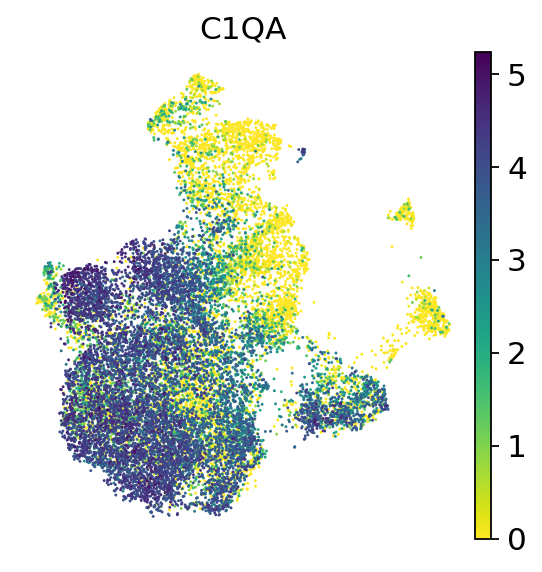

In [15]:
sc.pl.umap(adata, color="C1QA")

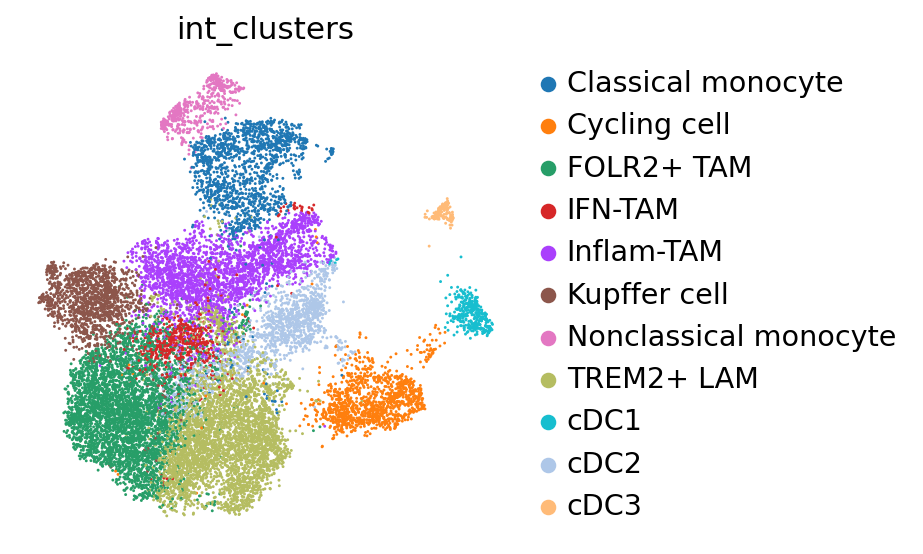

In [27]:
sc.pl.umap(adata, color=['int_clusters'])

In [37]:
adata.obs

patient_id condition sampletype  nCount_RNA  \
PNT1_GTTACGAAGAGGTTAT-1-0     scPNT1       PNT  scRNA-seq     50621.0   
PNT1_ACTGATGTCCTCACCA-1-0     scPNT1       PNT  scRNA-seq     48297.0   
PNT1_ATGGGTTTCGACACTA-1-0     scPNT1       PNT  scRNA-seq     45652.0   
PNT1_TCCATCGTCAGGAACG-1-0     scPNT1       PNT  scRNA-seq     43840.0   
PNT1_GGAACCCCAGAATTCC-1-0     scPNT1       PNT  scRNA-seq     41478.0   
...                              ...       ...        ...         ...   
RT3_GCTACAAAGTCTGCGC-1-1       snRT3        RT  snRNA-seq      3141.0   
RT3_GCCCAGAAGGGTGAGG-1-1       snRT3        RT  snRNA-seq      3030.0   
RT3_AAGTACCCAATGTCAC-1-1       snRT3        RT  snRNA-seq      2763.0   
RT3_ACTTAGGGTGTTAGCT-1-1       snRT3        RT  snRNA-seq      2393.0   
RT3_ATGGTTGAGGGTACAC-1-1       snRT3        RT  snRNA-seq      2345.0   

                           nFeature_RNA  mt_ratio  ribo_ratio  stress_ratio  \
PNT1_GTTACGAAGAGGTTAT-1-0          5905  3.812351    8.034069      4.782600   
PNT1_ACTGATGTCCTCACCA-1-0          5774  5.713774    7.924851      4.054082   
PNT1_ATGGGTTTCGACACTA-1-0          5709  0.852279    6.545587      6.825550   
PNT1_TCCATCGTCAGGAACG-1-0          5849  1.066439    9.525952      1.546533   
PNT1_GGAACCCCAGAATTCC-1-0          4768  6.567028    9.633771      7.934327   
...                                 ...       ...         ...           ...   
RT3_GCTACAAAGTCTGCGC-1-1           1870  0.058411    0.321262      0.063674   
RT3_GCCCAGAAGGGTGAGG-1-1           1857  0.092223    0.584076      0.198020   
RT3_AAGTACCCAATGTCAC-1-1           1716  9.765355    0.759144      0.217155   
RT3_ACTTAGGGTGTTAGCT-1-1           1555  0.118718    0.237436      0.083577   
RT3_ATGGTTGAGGGTACAC-1-1           1582  7.452681    0.709779      0.341151   

                            S.Score  G2M.Score Phase          celltype batch  \
PNT1_GTTACGAAGAGGTTAT-1-0 -0.061327  -0.082250    G1        Inflam-TAM     0   
PNT1_ACTGATGTCCTCACCA-1-0 -0.035037  -0.093689    G1        Inflam-TAM     0   
PNT1_ATGGGTTTCGACACTA-1-0 -0.016207  -0.034891    G1        Inflam-TAM     0   
PNT1_TCCATCGTCAGGAACG-1-0 -0.068893  -0.087227    G1      Kupffer cell     0   
PNT1_GGAACCCCAGAATTCC-1-0 -0.019100  -0.067479    G1        Inflam-TAM     0   
...                             ...        ...   ...               ...   ...   
RT3_GCTACAAAGTCTGCGC-1-1  -0.113691   0.046107   G2M            LA-TAM     1   
RT3_GCCCAGAAGGGTGAGG-1-1  -0.022353  -0.092155    G1  Classical M2 TAM     1   
RT3_AAGTACCCAATGTCAC-1-1   0.008281  -0.090765     S          Monocyte     1   
RT3_ACTTAGGGTGTTAGCT-1-1   0.047662  -0.069121     S      Kupffer cell     1   
RT3_ATGGTTGAGGGTACAC-1-1  -0.129734  -0.042601    G1          Monocyte     1   

                           _scvi_batch  _scvi_labels celltype_scanvi  \
PNT1_GTTACGAAGAGGTTAT-1-0            0             4      Inflam-TAM   
PNT1_ACTGATGTCCTCACCA-1-0            0             4      Inflam-TAM   
PNT1_ATGGGTTTCGACACTA-1-0            0             4      Inflam-TAM   
PNT1_TCCATCGTCAGGAACG-1-0            0             5    Kupffer cell   
PNT1_GGAACCCCAGAATTCC-1-0            0             4      Inflam-TAM   
...                                ...           ...             ...   
RT3_GCTACAAAGTCTGCGC-1-1             0            12         Unknown   
RT3_GCCCAGAAGGGTGAGG-1-1             0            12         Unknown   
RT3_AAGTACCCAATGTCAC-1-1             0            12         Unknown   
RT3_ACTTAGGGTGTTAGCT-1-1             0            12         Unknown   
RT3_ATGGTTGAGGGTACAC-1-1             0            12         Unknown   

                                C_scANVI scanvi_leiden        int_clusters  
PNT1_GTTACGAAGAGGTTAT-1-0     Inflam-TAM             2          Inflam-TAM  
PNT1_ACTGATGTCCTCACCA-1-0     Inflam-TAM             2          Inflam-TAM  
PNT1_ATGGGTTTCGACACTA-1-0     Inflam-TAM             2          Inflam-TAM  
PNT1_TCCATCGTCAGGAACG-1-0   Kupffer cell             4        Kupf

In [22]:
# condition visualization
adata.obs['condition'] = (
    adata.obs["condition"]
    .map(lambda x: {"PNT": "PNT", "PT": "PT", "RT": "PT"}.get(x, x))
    .astype("category")
)

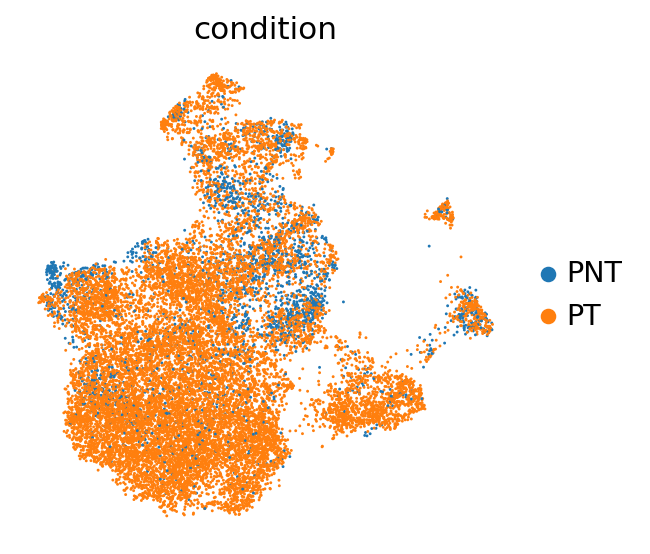

In [23]:
sc.pl.umap(adata, color=['condition'])

In [8]:
def cluster_small_multiples(
    adata, clust_key, size=60, frameon=False, legend_loc=None, **kwargs
):
    tmp = adata.copy()

    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=adata.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs,
    )

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


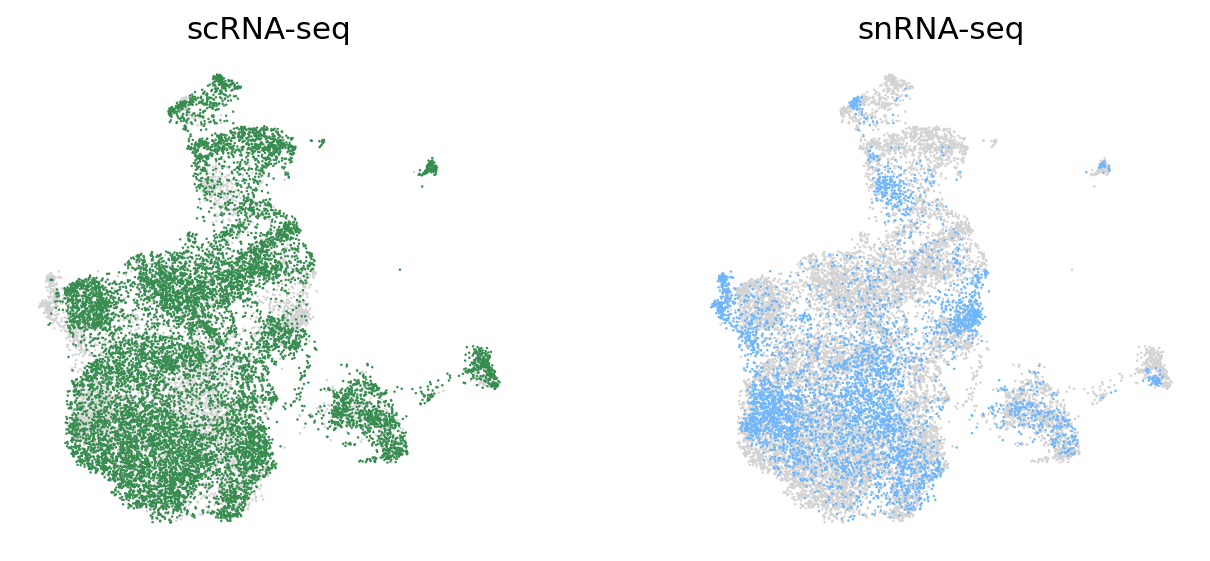

In [11]:
cluster_small_multiples(adata, clust_key = 'sampletype', size=5)

In [34]:
# downstream analysis
# marker visualization
markers = {
    'Classical monocyte': ['LYZ', 'S100A9'], 
    'Cycling cell': ['TOP2A', 'MKI67'], 
    'FOLR2+ TAM': ['FOLR2', 'MRC1', 'CD163'], # FOLR2+ CD163+ onco-fetal macrophage
    'IFN-TAM': ['IFIT1', 'IFI44L'], 
    'Inflam-TAM': ['CCL4', 'CCL3L1', 'IL1B'],  # inflammation
    'Kupffer cell': ['CD5L', 'VCAM1'],  # tissue resident
    'Nonclassical monocyte': ['FCGR3A', 'LILRB2'], 
    'TREM2+ LAM': ['TREM2', 'SPP1', 'FABP5'],  # lipid metabolism
    'cDC1': ['CLEC9A', 'CPNE3'], 
    'cDC2': ['CD1C', 'CLEC10A'], 
    'cDC3': ['LAMP3', 'CCR7'], 
}

In [92]:
# scale the scANVI normalized expression
x = adata.layers['scanvi_normalized'].copy()
sc.pp.scale(x, max_value=10)
adata.layers['scanvi_scaled'] = x

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


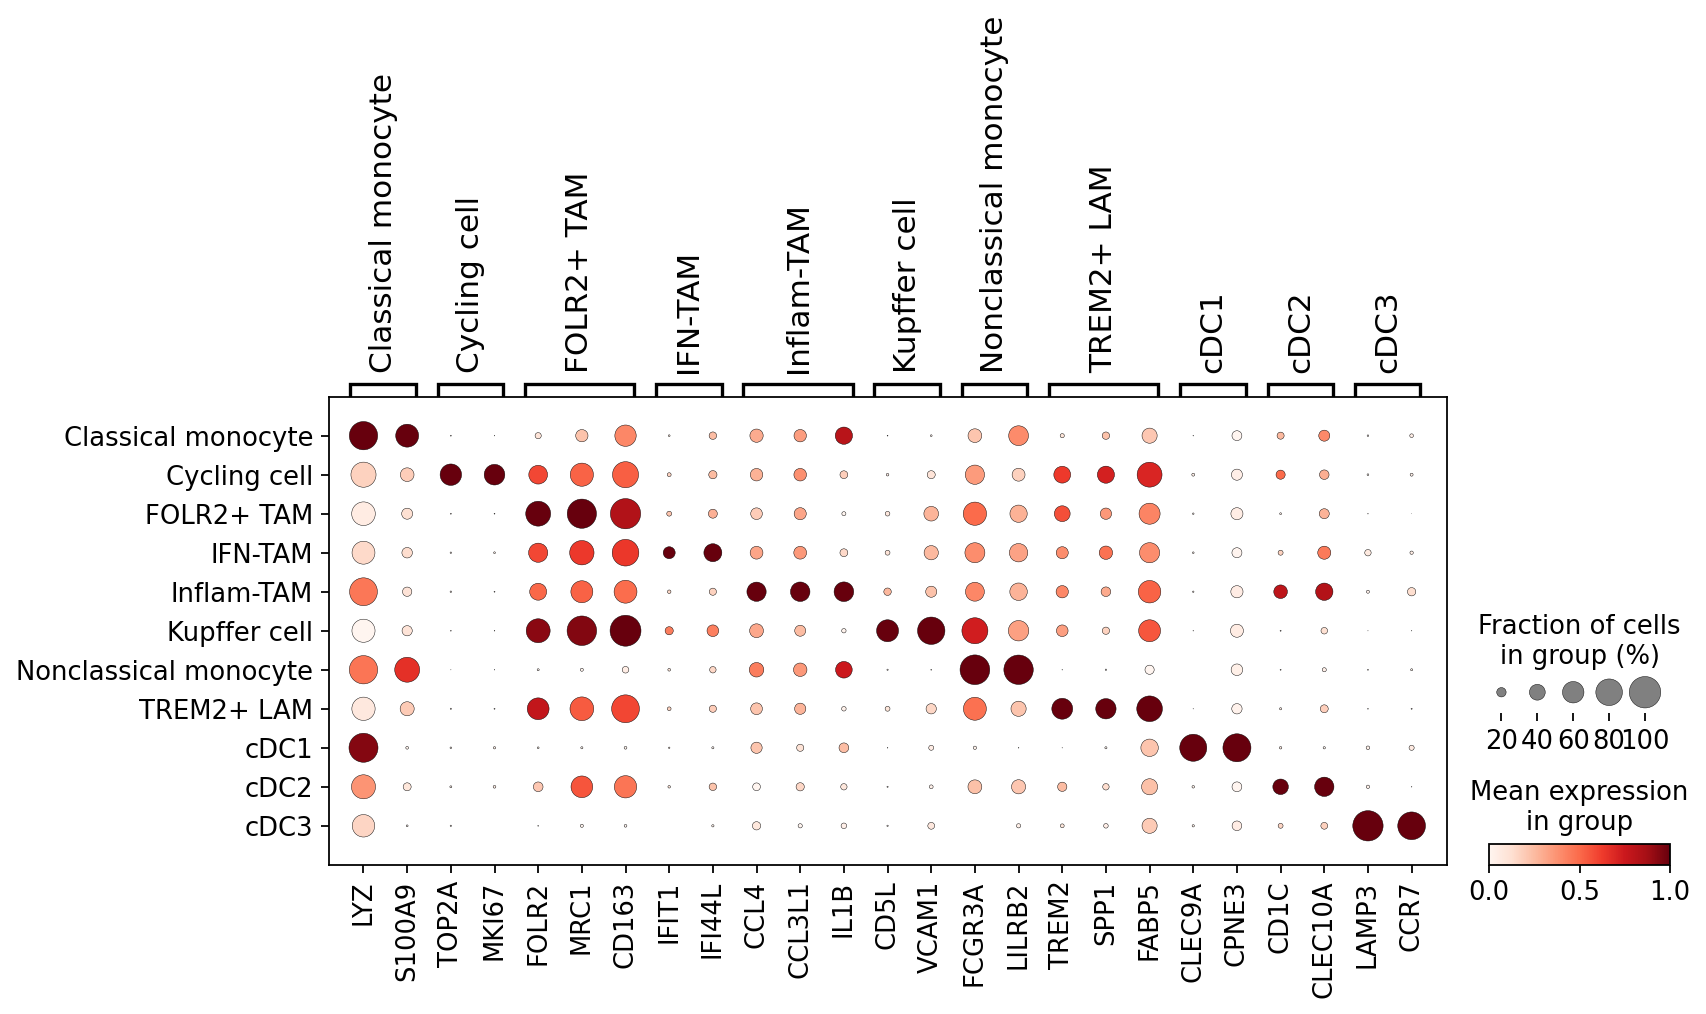

In [37]:
sc.pl.dotplot(adata, markers, 'int_clusters', color_map='Reds', use_raw=True, standard_scale='var', expression_cutoff=0.5, save="marker_myeloid.pdf")

In [68]:
# save good results
adata.write('scanvi_integrated.h5ad')